In [1]:
import pandas as pd
import bamboolib
import os
import datetime
import numpy as np
from matplotlib import pyplot
from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform


## Chemins des fichiers

In [3]:
#a changer localement
aymeric = "/home/aymeric/python-scripts/anses_medialab/datas/" #aymeric
jp = 'd:/Projects/Medialab/Anses/' # Jean Philippe


path_base = aymeric
file_segmentation = f"{path_base}segmentation_common_freq.csv"

index=f"{path_base}index_alldefault_nameexhaustive_aymeric.csv"

all_corpus = f"{path_base}all_corpus_seg_with_sdhi_PI.csv"

#twittos = f"{path_base}tweets_pesticides/500_first_twittos_on_pesticides.csv"



## Chargement des données

In [4]:
#df0 = pd.read_csv(all_corpus, sep = "\t")
df_index = pd.read_csv(index, sep = "\t")
dfseg = pd.read_csv(file_segmentation, sep = "\t")

df_index['date'] = pd.to_datetime(df_index['date'], infer_datetime_format=True)
df_index['yearmonth']=(df_index['date'].dt.strftime('%Y-%m'))

df_index['date'] = df_index['date'].dt.date

## Fusion segment + indexation

In [5]:
segment = dfseg[["yearmonth", "segm", "origin"]]


df0 = df_index.merge(segment, how = "inner", on = ["origin", "yearmonth"])
df0["start_segment"] = df0.groupby(['origin','segm'])["date"].transform('min')
df0["end_segment"] = df0.groupby(['origin','segm'])["date"].transform('max')


## Bump Chart

In [6]:
def ranked_element(data, which, top_rank):
    """
    data = the dataframe
    which = a string ; the variable that we want to rank and display on bump chart
    top_rank = an integer ; the rank that values should reach at least one time to be part of bump chart
    """
    
    df = (
        data
          .value_counts(["origin", which, 'segm', 'start_segment'])
          .groupby(["origin", "segm"])
          .rank("first", ascending=False)
          .rename("rank")
          .sort_index()
          .reset_index()
         )
    
    if top_rank is not None :
        df.loc[df["rank"] > top_rank, f"top_rank_{top_rank}"] = 0
        df.loc[df["rank"] < top_rank, f"top_rank_{top_rank}"] = 1
        df["count_rank"] = df.groupby(["origin",which])[f"top_rank_{top_rank}"].transform("sum")
        df = df.loc[df["count_rank"] >= 1]
    else:
        pass
    
    ## Compute correlation matrix for each origin
    
    new_df0 = pd.DataFrame(columns=["term", 'cluster', 'origin']) 
    list_Z = []
    for x in df["origin"].unique():
        t = pd.pivot_table(df.loc[df["origin"] == x], 
                           index = "segm", columns = "term", 
                           values = "rank", fill_value=0)
        
        dissimilarity = 1 - abs(t.corr())
        
  
        Z = linkage(squareform(dissimilarity), 'complete') 
        list_Z.append(Z)
        threshold = 0.8
        labels = fcluster(Z, threshold, criterion='distance')
    
        name = [x for x in t.columns]
        cluster = [y for y in labels]
    
        new_df = pd.DataFrame(data = {"term": name, "cluster": cluster})
        new_df["origin"] = x
        new_df0 = pd.concat([new_df0, new_df], axis=0, ignore_index=True)
    
    
    df = df.merge(new_df0, how = "left", on = ["origin",which])
    
    
    
    
    return df, list_Z, new_df0
    


In [7]:
def bump_chart(data, which):
    
    """
    data = the dataframe
    """
    
    list_origin = ["media", "twitter", "facebook"]


    for n, x in enumerate(list_origin):
    
        df = data.loc[data["origin"]== x]
        n_top_ranked = 10
        top_sources = df[df["segm"] == df["segm"].max()].nsmallest(n_top_ranked, "rank")

        fig, ax = plt.subplots(figsize=(16, 10), subplot_kw=dict(ylim=(0.5, 0.5 + n_top_ranked)))
        
        fig.suptitle(x, fontsize=16)


        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.yaxis.set_major_locator(MultipleLocator(1))

        yax2 = ax.secondary_yaxis("right")
        yax2.yaxis.set_major_locator(FixedLocator(top_sources["rank"].to_list()))
        yax2.yaxis.set_major_formatter(FixedFormatter(top_sources[which].to_list()))


        for i, j in df.groupby([which]):
            ax = plt.plot("segm", "rank", "o-", data=j)
            

        plt.gca().invert_yaxis()
    
    return fig

In [8]:
def interactive_bump_chart(data, which, cluster):

    if cluster is None :
        pass
    else:
        data["cluster"] = pd.to_numeric(data["cluster"])
        data = data.loc[data["cluster"] == cluster]
        
    fig = px.line(data, x="start_segment", y="rank", color = which, facet_row="origin").update_traces(mode='markers+lines')
    fig['layout']['yaxis']['autorange'] = "reversed"

    fig.show()

In [11]:
df, Z, new_df0 = ranked_element(data = df0, which="term", top_rank= 5)

In [12]:
bump = interactive_bump_chart(data = df, which = "term", cluster = None)

In [ ]:
z = Z[1]
dendrogram(z, orientation='top');

## Matrice de corrélation

In [13]:
df3 = df.loc[df["origin"] == "facebook"]
t = pd.pivot_table(df3, index = "segm", columns = "term", values = "rank", fill_value=0)

In [14]:
t

term  abeilles  agriculteur  coûts  culture  glyphosate  monde  monsanto  \
segm                                                                       
0.0         14            5     65       12          89      8         3   
1.0          5            4    142       15         136      6         3   
2.0          9           18     99       15          95      6         5   
3.0          3           13    142       10          86      6         2   
4.0          2           13    127        9          69      5         6   
5.0          5           12    112       15           7      6         2   
6.0          7           15    111       13           3      5         4   
7.0          6            7    117       13           2      5         4   
8.0          9            8    136       17           2      5         3   
9.0         13            5    102        7           2      4        37   
10.0        11           10    104        3           5      9        64   
11.0        

In [15]:
corrMatrix = t.corr()

In [16]:
corrMatrix

term             abeilles  agriculteur     coûts   culture  glyphosate  \
term                                                                     
abeilles         1.000000     0.267632 -0.851219 -0.516788   -0.268179   
agriculteur      0.267632     1.000000 -0.322881 -0.204854   -0.113523   
coûts           -0.851219    -0.322881  1.000000  0.653017    0.282550   
culture         -0.516788    -0.204854  0.653017  1.000000    0.339977   
glyphosate      -0.268179    -0.113523  0.282550  0.339977    1.000000   
monde            0.667147     0.254955 -0.743416 -0.631062   -0.029590   
monsanto         0.850154     0.322899 -0.831574 -0.840016   -0.391925   
néonicotinoïdes -0.075101    -0.150957  0.157091  0.114568    0.291673   
ogm              0.636233    -0.135796 -0.507268 -0.605655   -0.642669   
pesticides      -0.013657     0.084941 -0.380818 -0.509497   -0.191558   
plantes         -0.315111    -0.296581  0.581623  0.767384    0.097724   
production      -0.405342     0.156026

In [17]:
import scipy
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]


<AxesSubplot:xlabel='term', ylabel='term'>

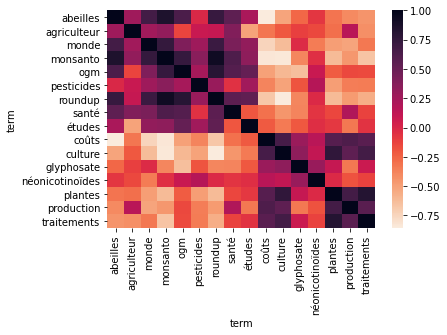

In [18]:
cmap = sns.cm.rocket_r
sns.heatmap(cluster_corr(corrMatrix), cmap = cmap)

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

plt.figure(figsize=(24,10))
dissimilarity = 1 - abs(corrMatrix)
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z, labels=t.columns, orientation='top');
